In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [69]:
df = pd.read_csv("/Users/darshmac/Documents/Cdac Project/Agartala_combined_data.csv")
df.head()

,Date,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
0,2004010106,11.97,11.30,11.63,101.33,101.51,0.43,8.24,95.50,0.0
1,2004010107,12.95,11.55,12.25,101.41,101.60,0.33,8.36,91.00,0.0
2,2004010108,15.06,11.97,13.51,101.49,101.67,0.07,8.61,81.62,0.0
3,2004010109,19.23,11.73,15.48,101.56,101.74,0.49,8.48,61.62,0.0
4,2004010110,21.79,11.19,16.48,101.50,101.68,0.60,8.18,50.81,0.0


In [70]:
not_req_col = ['T2MDEW','T2MWET','PS','PSC','WS2M','QV2M','RH2M','PRECTOTCORR']
drop_df = df.drop(columns=not_req_col)
drop_df

,Date,T2M
0,2004010106,11.97
1,2004010107,12.95
2,2004010108,15.06
3,2004010109,19.23
4,2004010110,21.79
...,...,...
175315,2024010101,15.17
175316,2024010102,14.68
175317,2024010103,14.21
175318,2024010104,13.77


In [8]:
# #Monthly Data
# monthly_data = drop_df.resample('M').mean()
# monthly_data.head()

In [71]:
# Convert the date column to datetime format
drop_df['Date'] = pd.to_datetime(drop_df['Date'], format='%Y%m%d%H')

In [72]:
drop_df['Date'] = pd.to_datetime(drop_df['Date'],infer_datetime_format=True)
hourly_df = drop_df.set_index(['Date'])
hourly_df.head(5)

,T2M
Date,
2004-01-01 06:00:00,11.97
2004-01-01 07:00:00,12.95
2004-01-01 08:00:00,15.06
2004-01-01 09:00:00,19.23
2004-01-01 10:00:00,21.79


In [29]:
#df_daily = df.resample('D', on='Date').max()
#later try converting hourly to daily

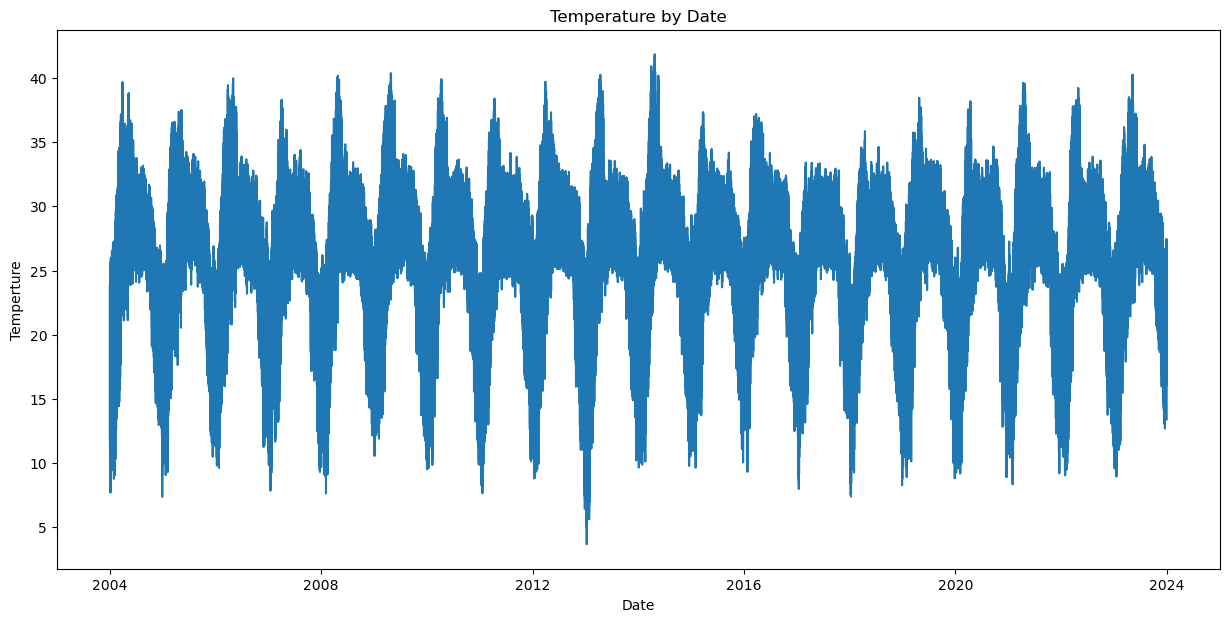

In [73]:
plt.figure(figsize=(15,7))
plt.title("Temperature by Date")
plt.xlabel('Date')
plt.ylabel('Temperture')
plt.plot(hourly_df)
plt.show()

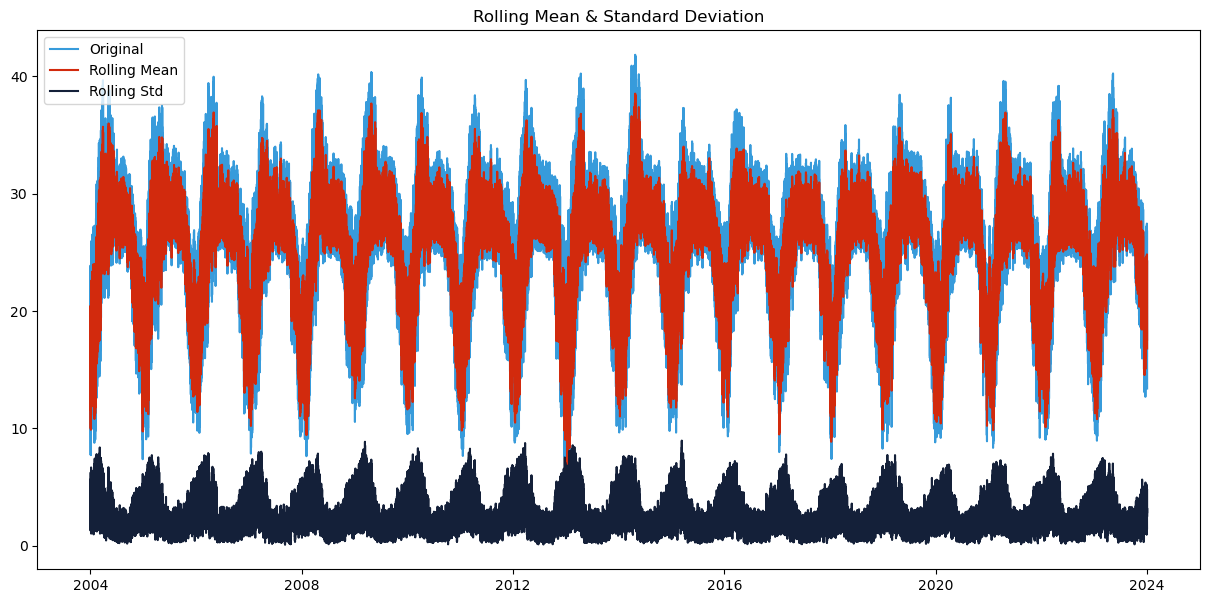

In [74]:
# #Determine rolling statistics
# hourly_df["rolling_avg"] = hourly_df["T2M"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
# hourly_df["rolling_std"] = hourly_df["T2M"].rolling(window=12).std()

# #Plot rolling statistics
# plt.figure(figsize=(15,7))
# plt.plot(df["T2M"], color='#379BDB', label='Original')
# plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
# plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
# plt.legend(loc='best')
# plt.title('Rolling Mean & Standard Deviation')
# plt.show(block=False)

# Assuming 'T2M' is the column for which you want to calculate the rolling average
hourly_df['rolling_avg'] = hourly_df['T2M'].rolling(window=12).mean()
hourly_df["rolling_std"] = hourly_df["T2M"].rolling(window=12).std()

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(hourly_df['T2M'], color='#379BDB', label='Original')
plt.plot(hourly_df['rolling_avg'], color='#D22A0D', label='Rolling Mean')
plt.plot(hourly_df['rolling_std'], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [75]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(hourly_df['T2M'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -8.075220e+00
p-value                        1.511865e-12
#Lags Used                     7.800000e+01
Number of Observations Used    1.752410e+05
Critical Value (1%)           -3.430387e+00
Critical Value (5%)           -2.861556e+00
Critical Value (10%)          -2.566779e+00
dtype: float64


In [47]:
pm.auto_arima?

Object `pm.auto` not found.


In [76]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(hourly_df['T2M'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

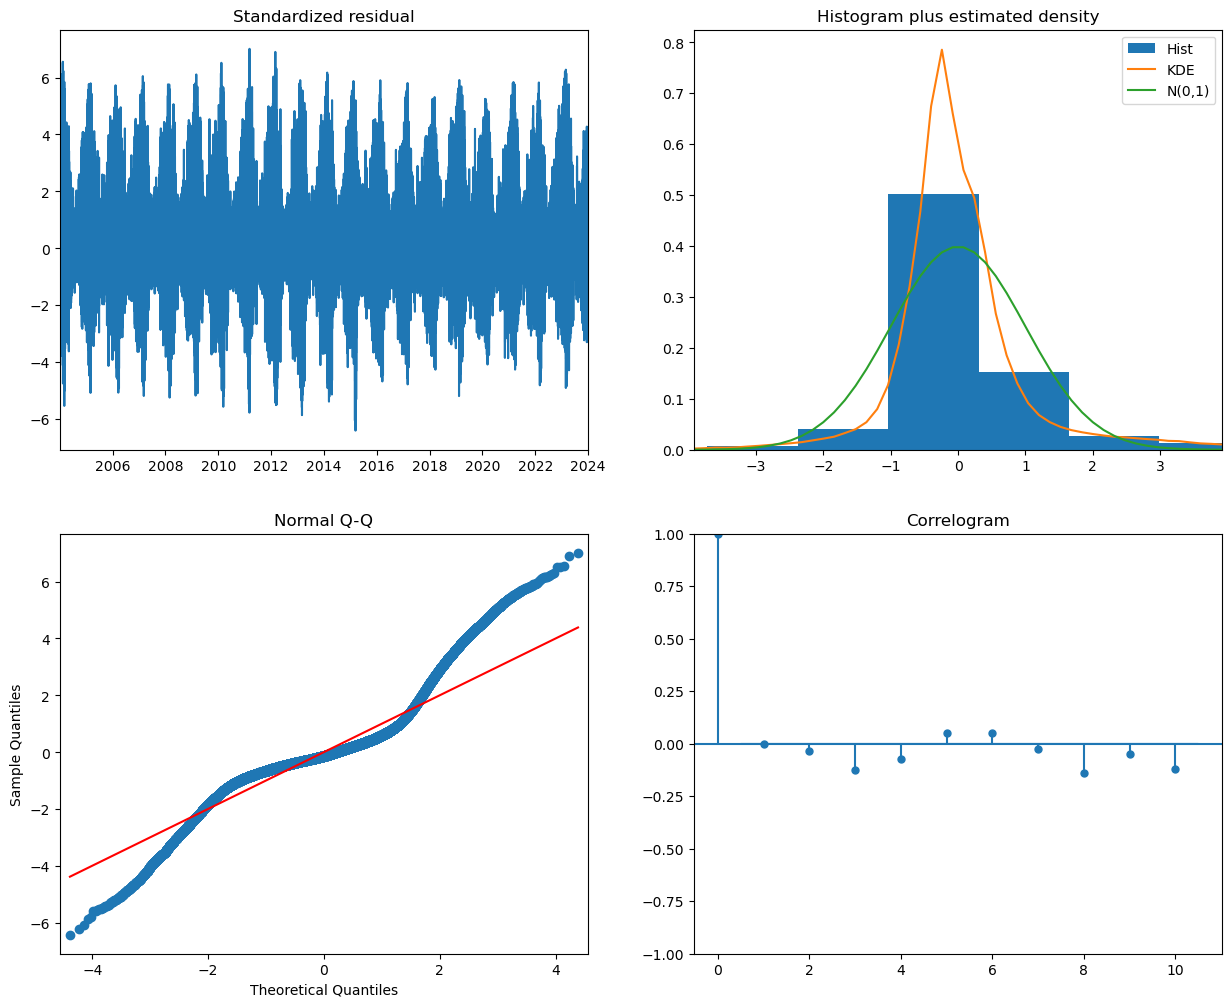

In [42]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

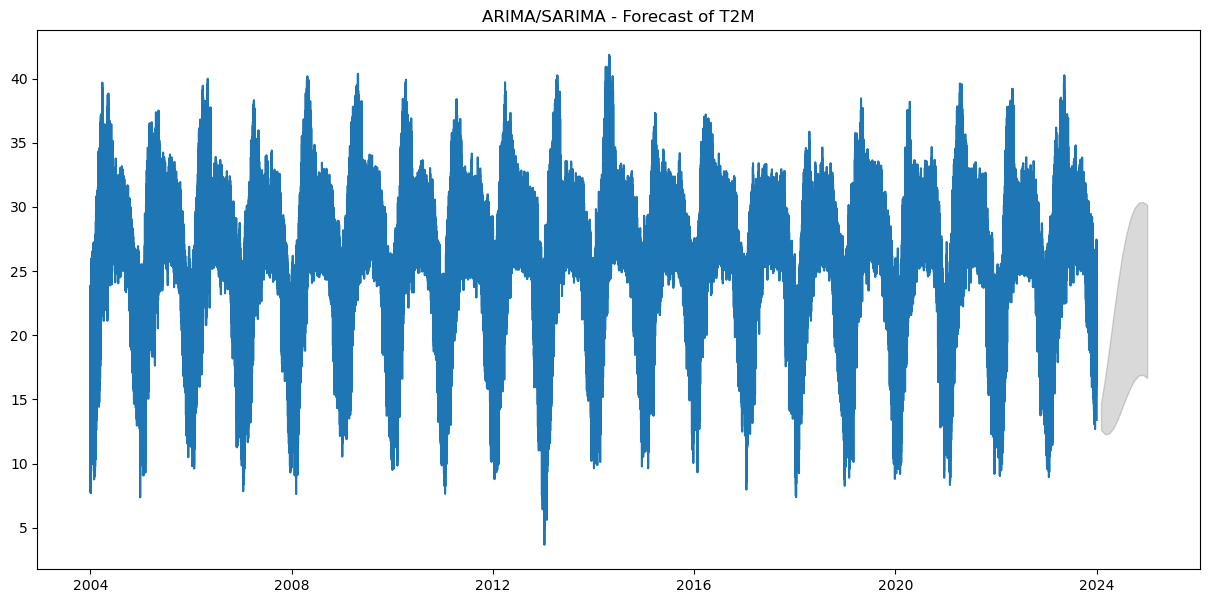

In [58]:
def forecast(ARIMA_model, periods=12):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(month_df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(month_df["T2M"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of T2M")
    plt.show()

forecast(ARIMA_model)

In [53]:
# Generate future predictions for 1 month
predictions = ARIMA_model.predict(n_periods=738)
print(predictions)
predictions.tail(30)

2024-01-01 06:00:00    13.660969
2024-01-01 07:00:00    14.471010
2024-01-01 08:00:00    15.684901
2024-01-01 09:00:00    17.142539
2024-01-01 10:00:00    18.684778
                         ...    
2024-01-31 19:00:00    19.842060
2024-01-31 20:00:00    19.841246
2024-01-31 21:00:00    19.840431
2024-01-31 22:00:00    19.839616
2024-01-31 23:00:00    19.838802
Freq: H, Length: 738, dtype: float64


2024-01-30 18:00:00    19.862440
2024-01-30 19:00:00    19.861624
2024-01-30 20:00:00    19.860808
2024-01-30 21:00:00    19.859993
2024-01-30 22:00:00    19.859178
2024-01-30 23:00:00    19.858362
2024-01-31 00:00:00    19.857547
2024-01-31 01:00:00    19.856731
2024-01-31 02:00:00    19.855916
2024-01-31 03:00:00    19.855101
2024-01-31 04:00:00    19.854285
2024-01-31 05:00:00    19.853470
2024-01-31 06:00:00    19.852655
2024-01-31 07:00:00    19.851840
2024-01-31 08:00:00    19.851025
2024-01-31 09:00:00    19.850210
2024-01-31 10:00:00    19.849394
2024-01-31 11:00:00    19.848579
2024-01-31 12:00:00    19.847764
2024-01-31 13:00:00    19.846949
2024-01-31 14:00:00    19.846135
2024-01-31 15:00:00    19.845320
2024-01-31 16:00:00    19.844505
2024-01-31 17:00:00    19.843690
2024-01-31 18:00:00    19.842875
2024-01-31 19:00:00    19.842060
2024-01-31 20:00:00    19.841246
2024-01-31 21:00:00    19.840431
2024-01-31 22:00:00    19.839616
2024-01-31 23:00:00    19.838802
Freq: H, d

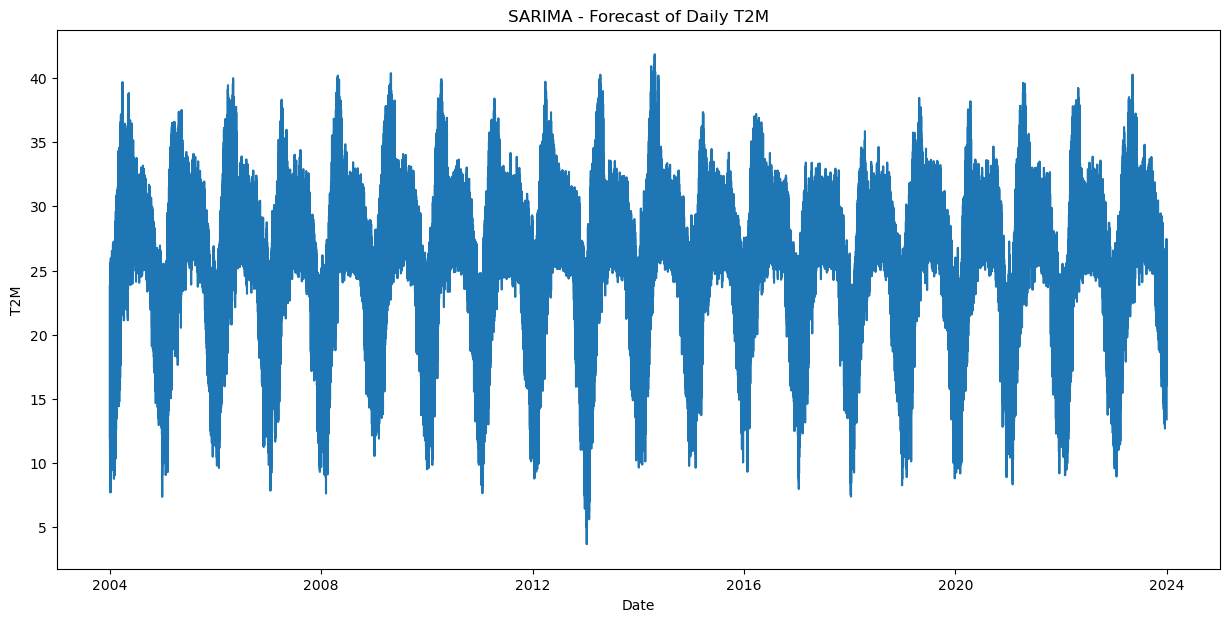

In [56]:
import matplotlib.pyplot as plt

# Forecast the daily time series
forecast = ARIMA_model.predict(n_periods=738)
forecast_df = pd.Series(forecast, index=month_df.index[-len(forecast):])

# Plot the forecasts and the daily time series
plt.figure(figsize=(15,7))
plt.plot(month_df["T2M"], color='#1f76b4')
plt.plot(forecast_df, color='darkgreen')
plt.title("SARIMA - Forecast of Daily T2M")
plt.xlabel("Date")
plt.ylabel("T2M")
plt.show()

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA


# Fit an ARIMA model to the time series data
ARIMA_model = ARIMA(month_df['T2M'], order=(5,1,0))
ARIMA_model_fit = ARIMA_model.fit()

/Users/darshmac/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/darshmac/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/darshmac/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [64]:
def forecast(ARIMA_model, periods=12):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(month_df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(month_df["T2M"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of T2M")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend(["Original", "Predicted"], loc="upper left")
    plt.show()
# Generate future predictions for 1 month
n_periods = 738
predictions = ARIMA_model_fit.predict(n_periods=n_periods)

# Create a pandas series for the predicted values
predicted_series = pd.Series(predictions, index=index_of_fc)

forecast(ARIMA_model_fit, periods=n_periods)

NameError: name 'index_of_fc' is not defined

In [65]:
import matplotlib.pyplot as plt

# Create a pandas series for the predicted values
predicted_series = pd.Series(predictions, index=index_of_fc)

# Plot the original time series data and the predicted values
plt.figure(figsize=(15,7))
plt.plot(month_df["T2M"], color='#1f76b4')
plt.plot(predicted_series, color='darkgreen')
plt.title("ARIMA/SARIMA - Forecast of T2M")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend(["Original", "Predicted"], loc="upper left")
plt.show()

NameError: name 'index_of_fc' is not defined

In [78]:
def forecast(ARIMA_model, periods=12):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(hourly_df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(month_df["T2M"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of T2M")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend(["Original", "Predicted"], loc="upper left")
    plt.show()

# Assuming 'Date' is the name of the date column in your DataFrame
hourly_df['Date'] = pd.to_datetime(hourly_df['Date'])
hourly_df.set_index('Date', inplace=True)

# Create a time variable as the number of days since the start of the series
hourly_df['Time'] = (month_df.index - month_df.index[0]).days

# Assuming ARIMA_model_fit is the fitted ARIMA model
ARIMA_model_fit = pm.auto_arima(hourly_df['T2M'], exogenous=month_df[['Time']], trace=False, suppress_warnings=True)

# Generate future predictions for 1 month
n_periods = 738
predictions = ARIMA_model_fit.predict(n_periods=n_periods)

# Create a pandas series for the predicted values
index_of_fc = pd.date_range(month_df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')
predicted_series = pd.Series(predictions, index=index_of_fc)

forecast(ARIMA_model_fit, periods=n_periods)

KeyError: 'Date'

In [79]:
print(hourly_df.columns)

Index(['T2M', 'rolling_avg', 'rolling_std'], dtype='object')


In [80]:
hourly_df.head()

,T2M,rolling_avg,rolling_std
Date,,,
2004-01-01 06:00:00,11.97,NaN,NaN
2004-01-01 07:00:00,12.95,NaN,NaN
2004-01-01 08:00:00,15.06,NaN,NaN
2004-01-01 09:00:00,19.23,NaN,NaN
2004-01-01 10:00:00,21.79,NaN,NaN


In [ ]:
#another way trial

In [81]:
# Assuming 'Date' is the name of the index in your DataFrame
hourly_df.index = pd.to_datetime(hourly_df.index)

# Create a time variable as the number of days since the start of the series
hourly_df['Time'] = (hourly_df.index - hourly_df.index[0]).days

# Assuming ARIMA_model_fit is the fitted ARIMA model
ARIMA_model_fit = pm.auto_arima(hourly_df['T2M'], exogenous=hourly_df[['Time']], trace=False, suppress_warnings=True)

# Generate future predictions for 1 month
n_periods = 738
predictions = ARIMA_model_fit.predict(n_periods=n_periods)

# Create a pandas series for the predicted values
index_of_fc = pd.date_range(hourly_df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')
predicted_series = pd.Series(predictions, index=index_of_fc)

forecast(ARIMA_model_fit, periods=n_periods)


KeyboardInterrupt: 